# LRP

Implementation of Layer-wise Relevance Propagation (LRP) in PyTorch.

Note:
Max-pooling layers are handled using the winner-takes-all strategy and not the sum-pooling-layer-rules strategy.

## Setup

Load model and input data.

In [1]:
import numpy
import torch
from lrp.image import (img_to_tensor, load_normalized_img)

img: numpy.array = load_normalized_img('castle.jpg')
X: torch.Tensor = img_to_tensor(img)

import torchvision
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Omit printing the model
None

Variables for $z^\mathcal{B}$-Rule

In [2]:
from lrp.norm import ILSVRC2012_BatchNorm
from typing import Tuple, Callable

batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)
norm_fn: Callable[[torch.Tensor], torch.Tensor] = ILSVRC2012_BatchNorm()

# Parameters
low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

## Rule-Layer Mapping

Define helpers for mapping rules to layers.

In [3]:
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

## Heatmap

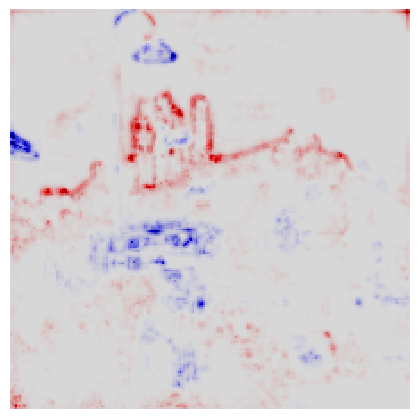

In [4]:
from lrp.core import LRP

lrp = LRP(model)
lrp.convert_layers(name_map)
R: torch.Tensor = lrp.relevance(X)
lrp.heatmap()

In [5]:
lrp.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

## Hyperparameter Grid Search

### Gamma Rule

In [6]:
gammas: numpy.ndarray = numpy.linspace(0.0, 1.0, num=20)
numpy.savetxt(fname='gammas.csv', X=gammas, newline=',')

# Rule-Layer Mapping
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': None}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]


results: List[Tuple[float, torch.Tensor]] = [None]*len(gammas)
for i, gamma in enumerate(gammas):
    # Set gamma hyperparameter
    name_map[1][2]['gamma'] = gamma
    # print('gamma: ', gamma)

    lrp = LRP(model)
    lrp.convert_layers(name_map)
    R: torch.Tensor = lrp.relevance(X)
    results[i] = (gamma, R)

### Grid plot

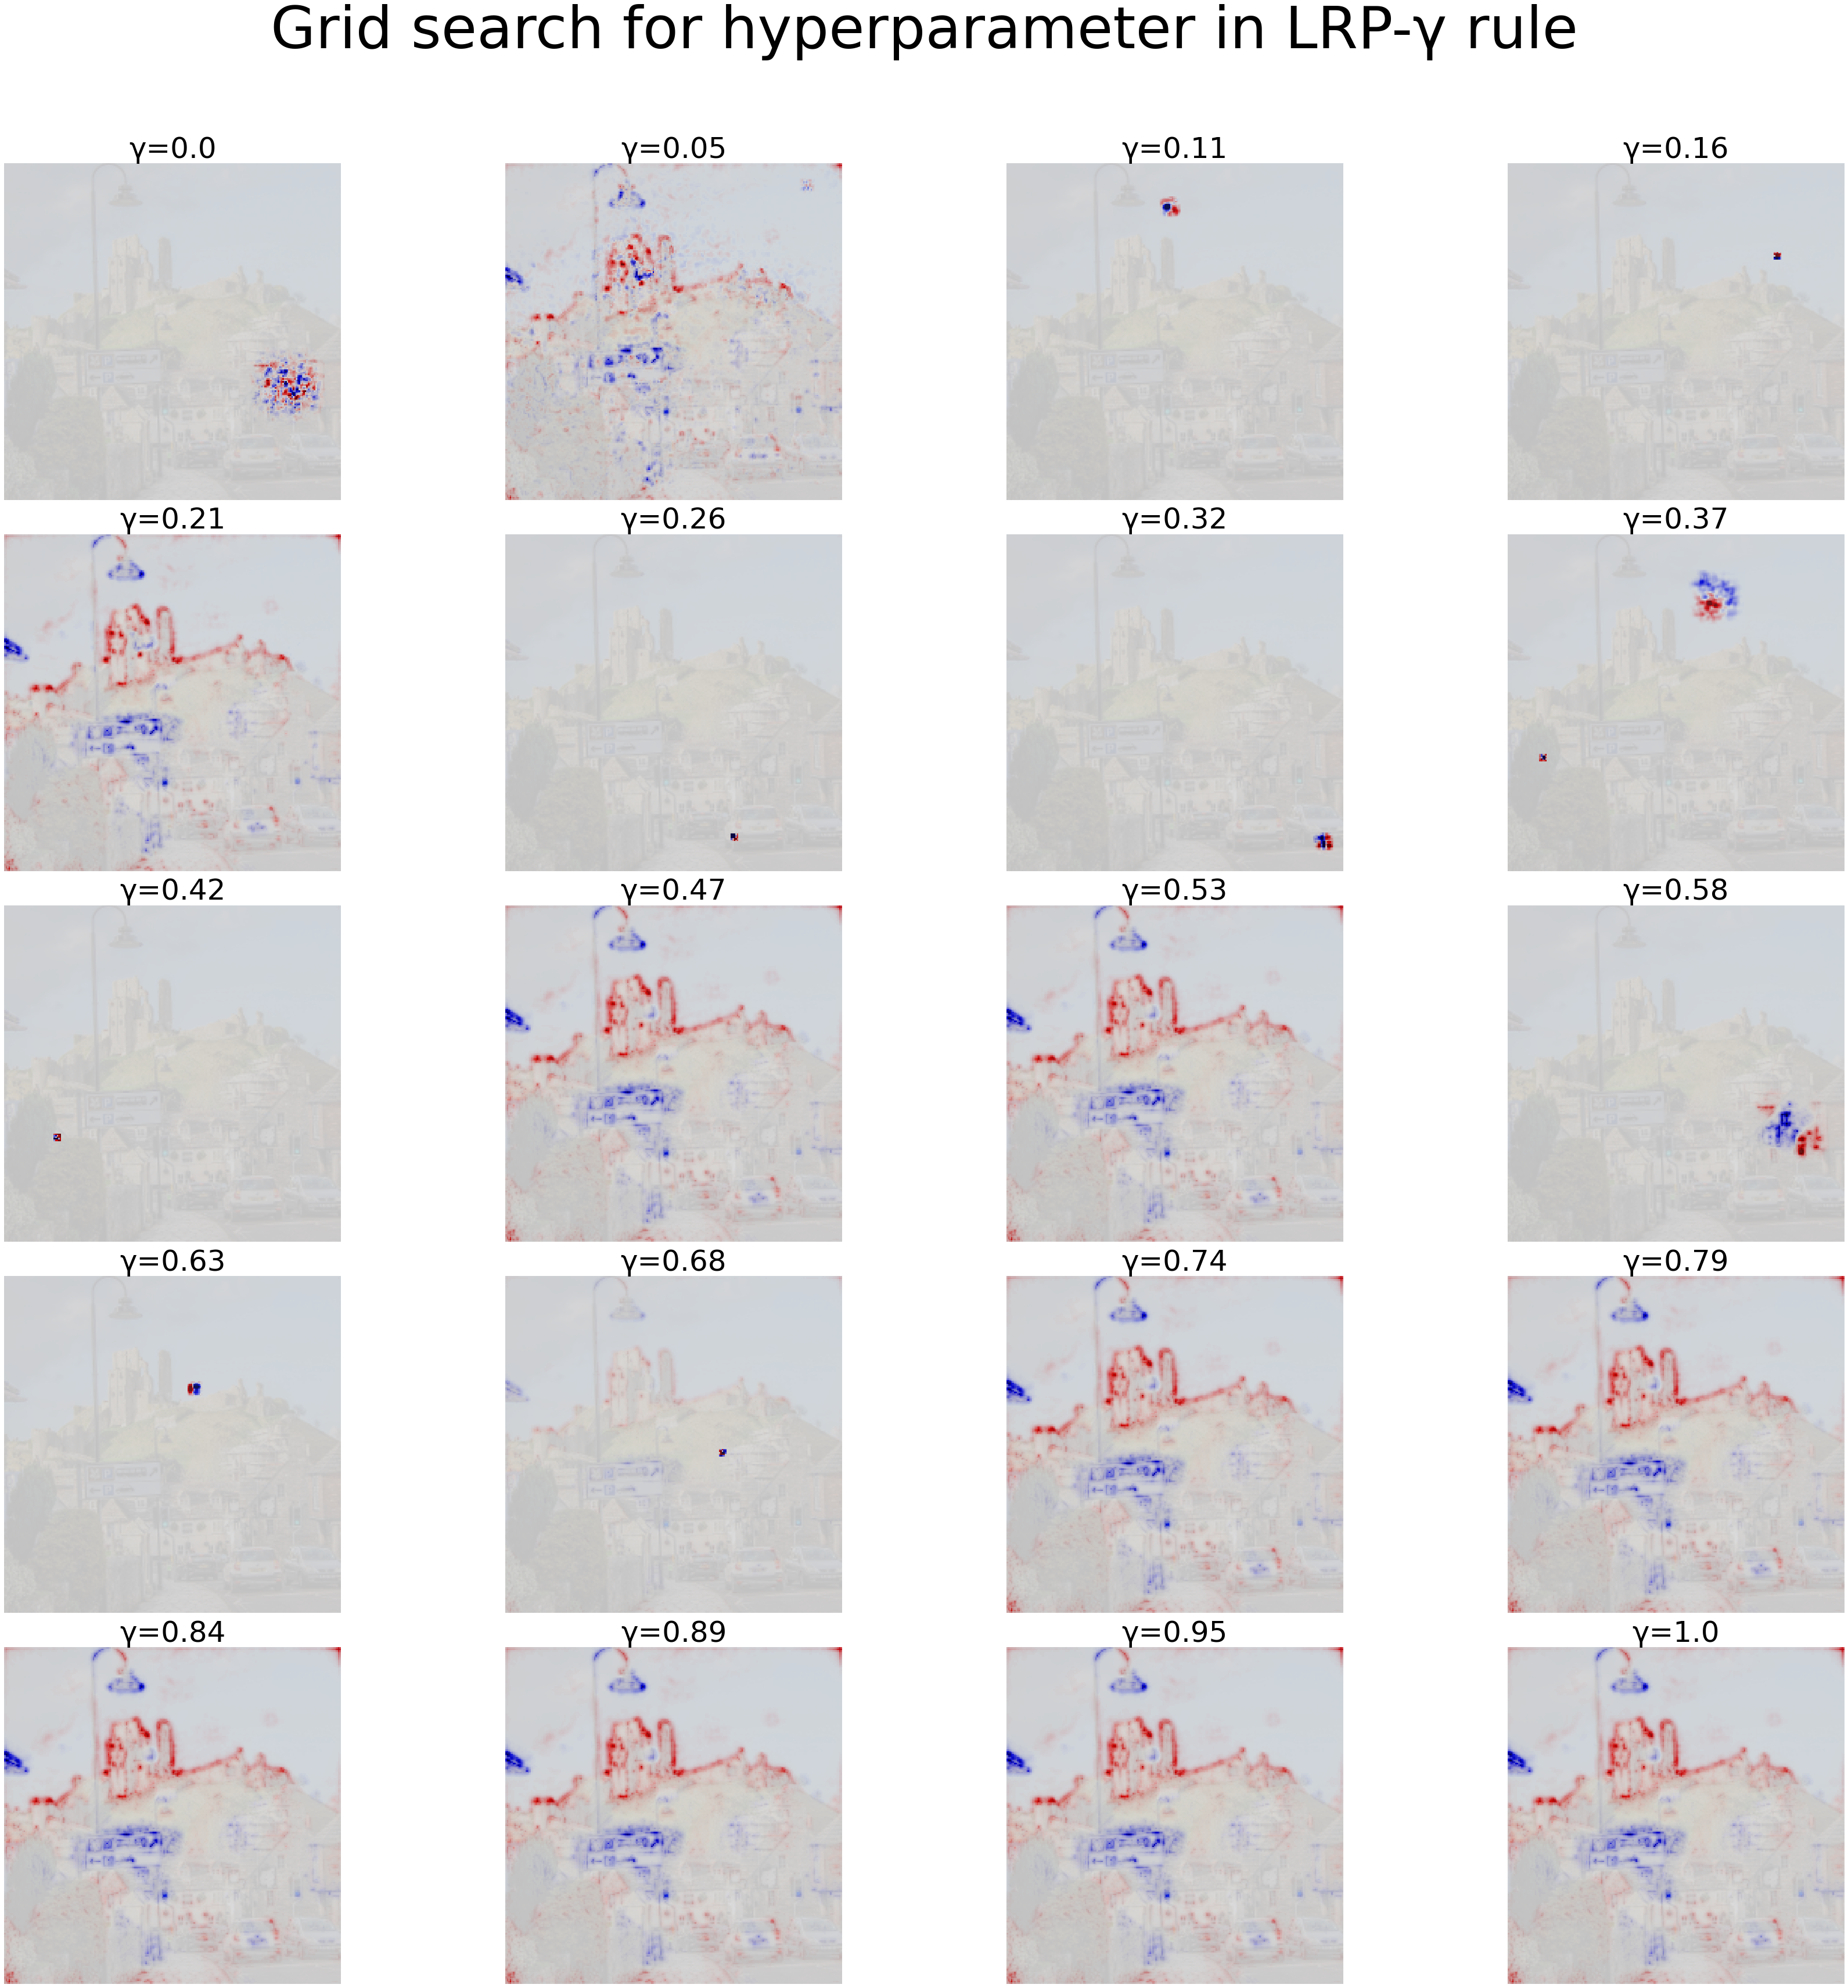

In [11]:
# Source: https://stackoverflow.com/a/46616645

import matplotlib.pyplot as plt
import lrp.image

# settings
ROWS, COLS = 5, 4  # array of sub-plots = len(gammas)
FIGSIZE = [50, 50] # figure size, inches
HEIGHT, WIDTH = 1, 1
FONTSIZE = FIGSIZE[0]*2
DPI = 300

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=ROWS, ncols=COLS, figsize=FIGSIZE)
fig.suptitle('Grid search for hyperparameter in LRP-γ rule', fontsize=FONTSIZE)

# plot simple raster image on each sub-plot
for i, ax_i in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # ax_i is equivalent with ax[row_id][col_id]

    gamma, R = results[i]

    # heatmap of relevance scores
    lrp.image.plot_heatmap(relevance_scores=R[0].sum(dim=0).detach().numpy(), width=WIDTH, height=HEIGHT, fig=ax_i, show_plot=False, dpi=DPI)

    ax_i.imshow(img, alpha=0.1)
    ax_i.axis('off')

    ax_i.set_title(f'γ={round(gamma,2)}', fontsize=FONTSIZE*0.5)

# Add padding for better alignment of suptitle
# https://stackoverflow.com/a/45161551
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("high-res-gammas-lrp.png", dpi=200, facecolor="w")

# ToDo:

## Today

- Create a function for grid search plots

## Tomorrow

- Start writing thesis
- Prepare slides for meeting with Gregoire
  - Include a visual mapping of layers to rules
- Check reading list (slides on representation learning)

### Context 

Try to visualize network structure (perhaps using graphs). Saved links to reading list.

Found this repo which creates saliency maps for images:
- Find out which algorithm is used in [flashtorch](https://github.com/MisaOgura/flashtorch) to compute saliency maps.
  - Check ~/Downloads/flashtorch


---


## Nice-to-haves

- **Try seaborn for [heatmapping](https://seaborn.pydata.org/generated/seaborn.heatmap.html)**
- **Heuristic for `stabilize` function to scale epsilon according to dividend**
<!-- - Remove empty parameter for LrpZeroRule (set default value for `rule_kwargs` to `{}`) -->
- Implement debug function to print with toggle and remove print statements
- Use torchvision.transforms.Compose
- Integrate DataLoader into notebook
- Canonize models
